# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202208

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

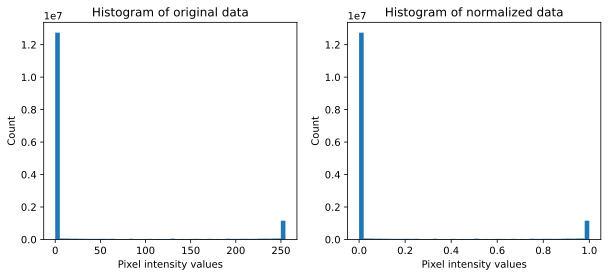

In [10]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
# ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
# ax[0].set_yscale('log')

plt.show()

# Create train/test groups using DataLoader

In [11]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [12]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
fig                Figure           Figure(720x288)
labels             ndarray          20000: 20000 elems, type `float64`, 1

# Create the DL model

In [13]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
      # NLLLoss = Negative Log Likelihood Loss
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
#   optimizer = torch.optim.Adam(net.parameters(),lr=.01)


  return net,lossfun,optimizer

In [14]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next() # get the first batch of the data   
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3015, grad_fn=<NllLossBackward0>)


In [15]:
yHat.shape

torch.Size([32, 10])

In [17]:
yHat[10]

tensor([-2.1757, -2.3000, -2.3913, -2.4772, -2.4322, -2.4072, -2.2832, -2.2377,
        -2.2095, -2.1681], grad_fn=<SelectBackward0>)

In [21]:
# The raw output is in log, so applying the exp you can access to the probabilities
torch.exp(yHat)[10]

tensor([0.1135, 0.1003, 0.0915, 0.0840, 0.0878, 0.0901, 0.1020, 0.1067, 0.1098,
        0.1144], grad_fn=<SelectBackward0>)

# Create a function that trains the model

In [22]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [23]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


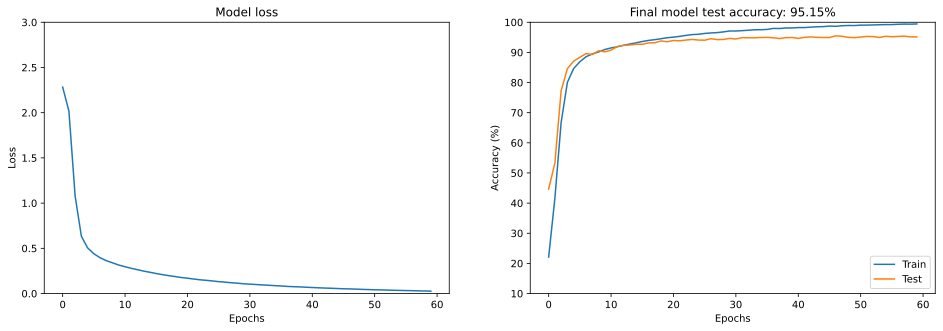

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [25]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-1.1021e+01, -1.2197e+01, -7.1111e+00,  ..., -1.6956e+01,
         -9.1063e+00, -1.8063e+01],
        [-2.3901e+01, -1.2638e+01, -1.4618e+01,  ..., -2.9714e-04,
         -1.7020e+01, -8.4625e+00],
        [-1.9684e+01, -2.2543e-03, -8.4091e+00,  ..., -6.5381e+00,
         -7.8630e+00, -1.3029e+01],
        ...,
        [-2.0790e+01, -1.0294e+01, -1.3209e+01,  ..., -2.0359e-04,
         -1.2799e+01, -9.6154e+00],
        [-1.1921e-06, -3.9572e+01, -1.3873e+01,  ..., -3.0499e+01,
         -1.5363e+01, -2.1199e+01],
        [-1.4512e+01, -1.2013e+00, -9.5829e+00,  ..., -9.0060e+00,
         -3.8298e-01, -7.4322e+00]])

In [35]:
print(torch.exp(predictions)[0])
print(torch.argmax(torch.exp(predictions)[0]))

tensor([1.6350e-05, 5.0474e-06, 8.1603e-04, 5.2534e-07, 2.7136e-03, 2.9512e-05,
        9.9631e-01, 4.3258e-08, 1.1096e-04, 1.4305e-08])
tensor(6)


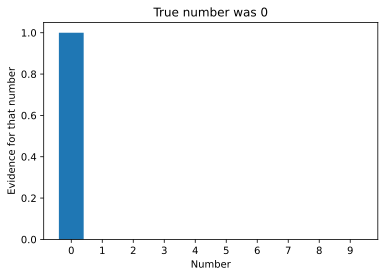

In [39]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  69  113  230  246  248  280  357  369  370  377  394  398  422  438
  471  605  618  621  624  627  629  633  665  667  669  688  704  729
  750  794  818  819  837  839  858  923  948  953  972  978  982 1003
 1040 1052 1066 1074 1087 1105 1129 1134 1135 1142 1215 1235 1244 1299
 1309 1319 1347 1349 1351 1357 1385 1400 1406 1415 1419 1478 1502 1536
 1548 1561 1595 1662 1672 1707 1725 1736 1740 1757 1766 1775 1816 1818
 1835 1875 1894 1895 1917 1926 1946 1947 1957 1969 1975 1982 1990]


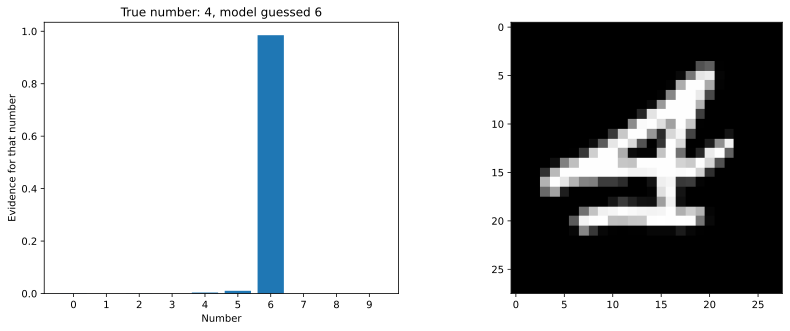

In [37]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 